# Creating a document-specific Chatbot with open source language models 

## Python set up

### 1. Creating and activating a virtual environment

In [ ]:
!python -m venv ../venv

In [ ]:
!source ../venv/bin/activate

### 2. Install python packages

In [ ]:
!pip install -r ../requirements.txt

### 3. Install Ollama
    3.1. Open [https://ollama.com/download](https://ollama.com/download) in any browser.
    3.2. Select OS of the current system being used.
    3.3. Navigate to the directory of download
    3.4. Unzip Ollama-*.zip (depends on OS)
    3.5. Open Ollama by double-clicking on the application
    3.6. Follow the instruction to further set it up
    3.7. Fetch a model via `ollama pull phi`

In [ ]:
!ollama pull phi

## Question Answering with Langchain and Ollama

### Load dataset

In [ ]:
import pandas as pd
df = pd.read_csv('../data/bbc_news_20220307_20240703.csv')

### Data discovery and cleaning (if needed)

In [ ]:
df.columns

In [ ]:
df.head(5)

In [ ]:
df.isna().sum()

In [ ]:
df['pubDate']

In [ ]:
df["pubDate"] = pd.to_datetime(df["pubDate"])
df["pubDate_str"] = df["pubDate"].dt.strftime("%Y-%m-%d %H:%M:%S")

### Create Document Object

In [ ]:
from langchain_core.documents import Document

docs = [Document(page_content=i['description'],
                metadata={
                    "guid": i['guid'], 
                    "pubDate_str": i['pubDate_str'], 
                    "title": i['title'],
                    "link": i['link']
                })
        
        for idx, i in df.iterrows()]

### Text Chunking

**Why is chunking important?**
- You can't pass unlimited data to a language model
    - Applications have a context limit
        - Limit on the amount of words/tokens you can pass to the language model
    - Signal to Noise
        - Remove information that isn't helpful to your task


**Concepts to know:**
- Chunk size: The number of characters to be chunked. 50, 100, 100,000, etc.
- Chunk overlap: The amount overlap of chunks. This is to try to avoid cutting a single piece of context into multiple pieces. This will create duplicate data across chunks.






*Level 1: Character Splitting*
- Most basic form of splitting up your text
- Process of simply dividing your text into N-character sized chunks regardless of their  content or form
Pros:
- Easy & Simple
Cons:
- Very rigid and doesn't take into account the structure of the text

Note: Not recommend for any application but a good starting point to understand basics

<br>

*Level 2: Recursive Character Text Splitting*

Character Splitting didn't take into consideration the structure of our document at all. It just splits text by a fix number of characters.

Recursive Character Text Splitting, as the name suggests, takes into a account a series of separators to split the text/document; commonly used separators are - "\n\n" (paragraph breaks), "\n" (new line), " " (spaces), "" (characters)



*Level 3: Document Specific Splitting*

3.1. Markdown Text Splitter:
- Separators:
    - \n#{1, 6} - Split by new lines followed by a header (H1 through H6)
    - ```\n - code blocks
    - \n\\*\\*\\*+\n - Horizontal Lines
    - \n____+\n - Horizontal Lines
    - \n\n - Double new lines
    - \n - New line
    - " " - Spaces
    - "" - Character
		
3.2. Python Code Text Splitter
- Separators:
    - \nclass - Classes first
    - \ndef - Functions next
    - \n\tdef - Indented functions
    - \n\n - Double New lines
    - \n - New lines
    - " " - Spaces
    - "" - Characters
    
    
    
*Level 4: Semantic Chunking*

All methods levels 1 - 3, we took into account physical positioning and assumed each chunk or paragraphs contains similar information.

Cons:
- Little bit more expensive
- More work 
- Slower
Pros:
- Takes into account meaning and content of the chunks

Analogy:
Levels 1 - 3 are like sorting books as per their height or size of the shelves.
But Semantic Chunking takes into account sorting by genre,  author or content


Visualize Chunking: https://chunkviz.up.railway.app/

In [ ]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
splits = text_splitter.split_documents(docs)

### Add Documents to VectorDB

In [ ]:
from langchain_chroma import Chroma
from langchain_community.embeddings.sentence_transformer import (
    SentenceTransformerEmbeddings,
)

# create the open-source embedding function
embedding_function = SentenceTransformerEmbeddings(model_name="all-MiniLM-L6-v2")

# load it into Chroma
vectorstore = Chroma.from_documents(splits, embedding_function, persist_directory="./chroma_db")

### Query vectordb

In [ ]:
query = 'What can you tell me about the bomb blast in Pakistan in 2023'
docs = vectorstore.similarity_search_with_score(query)

for idx, (result, score) in enumerate(docs):        
    print(f"Document {idx+1}:\n")
    print(result.page_content)
    print(f"\nMetadata: ", result.metadata)
    print(f"\nScore: ", score)
    print("-"*100)

## What is a 𝗩𝗲𝗰𝘁𝗼𝗿 𝗗𝗮𝘁𝗮𝗯𝗮𝘀𝗲?

With the rise of Foundational Models, Vector Databases skyrocketed in popularity. The truth is that a Vector Database is also useful outside of a Large Language Model context.

When it comes to Machine Learning, we often deal with Vector Embeddings. Vector Databases were created to perform specifically well when working with them:

➡️ Storing.<br>
➡️ Updating.<br>
➡️ Retrieving.

When we talk about retrieval, we refer to retrieving set of vectors that are most similar to a query in a form of a vector that is embedded in the same Latent space. This retrieval procedure is called Approximate Nearest Neighbour (ANN) search.

A query here could be in a form of an object like an image for which we would like to find similar images. Or it could be a question for which we want to retrieve relevant context that could later be transformed into an answer via a LLM.

Let’s look into how one would interact with a Vector Database:

𝗪𝗿𝗶𝘁𝗶𝗻𝗴/𝗨𝗽𝗱𝗮𝘁𝗶𝗻𝗴 𝗗𝗮𝘁𝗮.

1. Choose a ML model to be used to generate Vector Embeddings.
2. Embed any type of information: text, images, audio, tabular. Choice of ML model used for embedding will depend on the type of data.
3. Get a Vector representation of your data by running it through the Embedding Model.
4. Store additional metadata together with the Vector Embedding. This data would later be used to pre-filter or post-filter ANN search results.
5. Vector DB indexes Vector Embedding and metadata separately. There are multiple methods that can be used for creating vector indexes, some of them: Random Projection, Product Quantization, Locality-sensitive Hashing.
6. Vector data is stored together with indexes for Vector Embeddings and metadata connected to the Embedded objects.

𝗥𝗲𝗮𝗱𝗶𝗻𝗴 𝗗𝗮𝘁𝗮.

7. A query to be executed against a Vector Database will usually consist of two parts:

➡️ Data that will be used for ANN search. e.g. an image for which you want to find similar ones.
➡️ Metadata query to exclude Vectors that hold specific qualities known beforehand. E.g. given that you are looking for similar images of apartments - exclude apartments in a specific location.

8. You execute Metadata Query against the metadata index. It could be done before or after the ANN search procedure.
9. You embed the data into the Latent space with the same model that was used for writing the data to the Vector DB.
10. ANN search procedure is applied and a set of Vector embeddings are retrieved. Popular similarity measures for ANN search include: Cosine Similarity, Euclidean Distance, Dot Product.

Some popular Vector Databases: Qdrant, Pinecone, Weviate, Milvus, Faiss, Vespa.

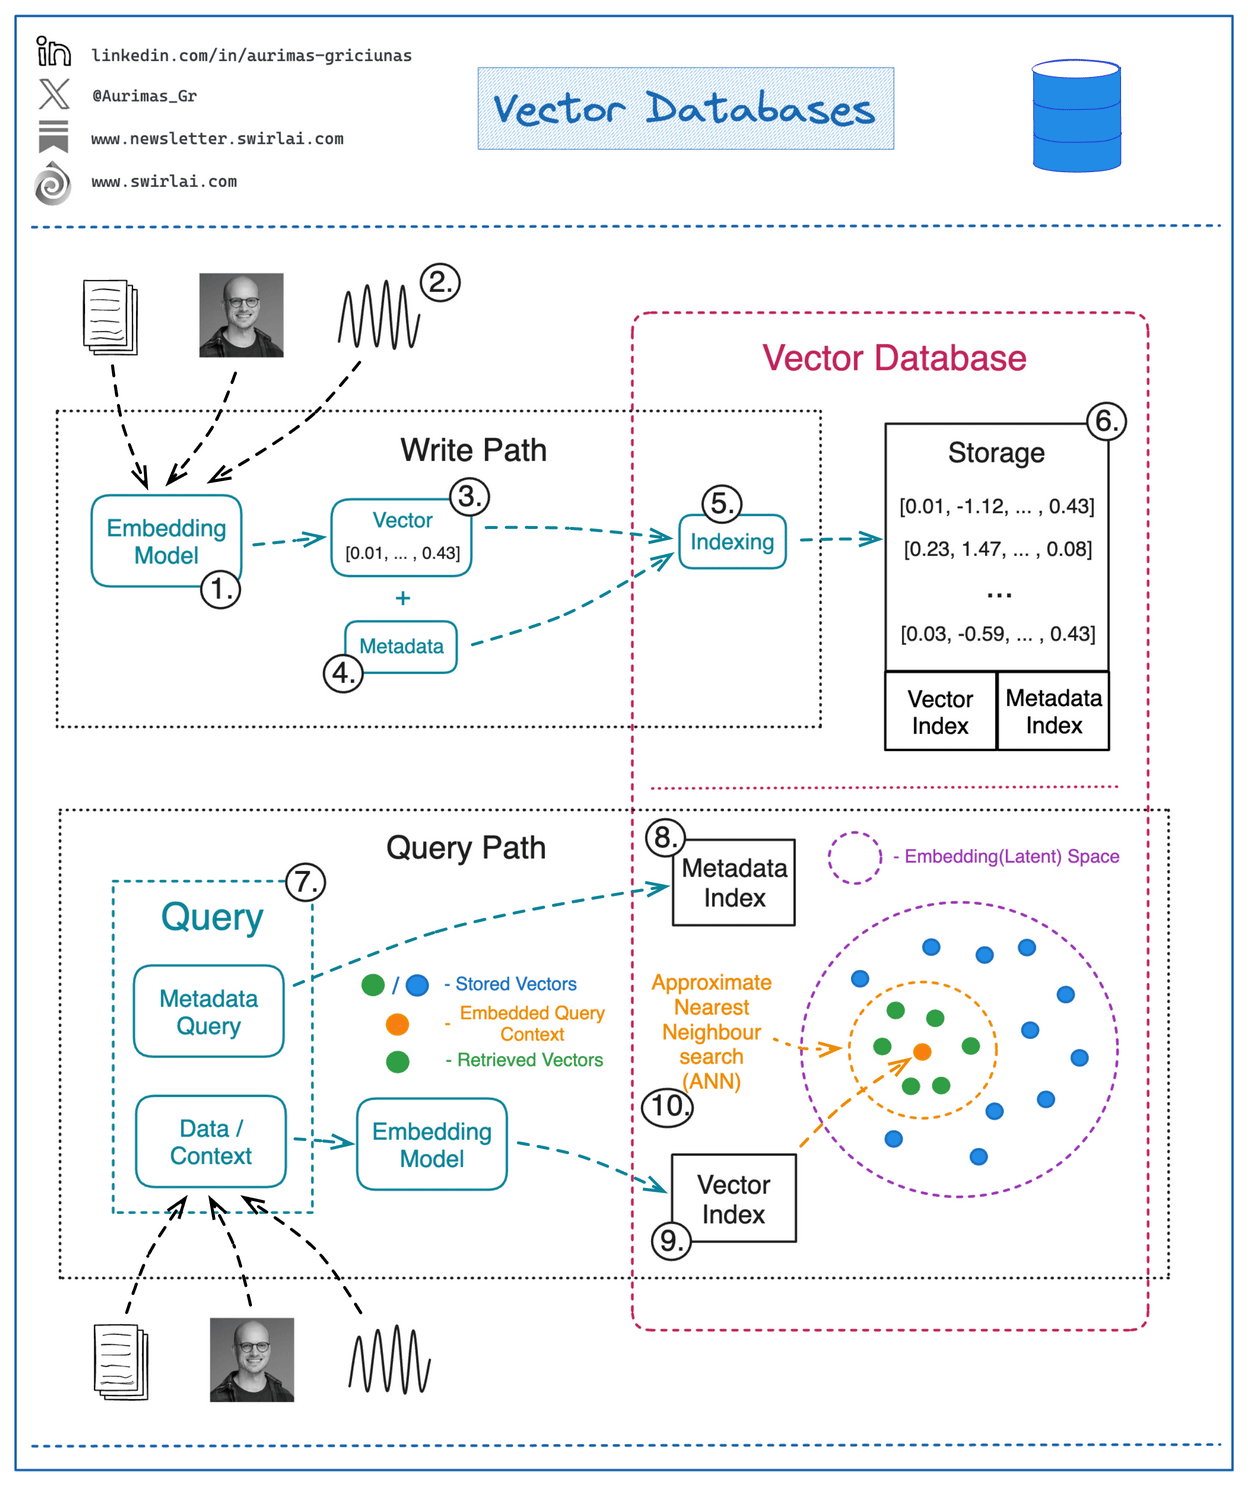

In [ ]:
retriever = vectorstore.as_retriever(search_type="similarity", search_kwargs={"k": 6})

### Initialize LLM

In [ ]:
from langchain_community.llms import Ollama

In [ ]:
model_name = 'phi'

# The temperature of the model. Increasing the temperature will make the model answer more creatively. (Default: 0.8)
temperature = 0.7

# Reduces the probability of generating nonsense. A higher value (e.g. 100) will give more diverse answers, while a lower value (e.g. 10) will be more conservative. (Default: 40)
top_k = 1

# Works together with top-k. A higher value (e.g., 0.95) will lead to more diverse text, while a lower value (e.g., 0.5) will generate more focused and conservative text. (Default: 0.9)
top_p = 0.9

# Maximum number of tokens to predict when generating text. (Default: 128, -1 = infinite generation, -2 = fill context)
max_tokens = 512

# Sets how strongly to penalize repetitions. A higher value (e.g., 1.5) will penalize repetitions more strongly, while a lower value (e.g., 0.9) will be more lenient. (Default: 1.1)
repeat_penalty = 0.0 

In [ ]:
llm = Ollama(
    model="phi", 
    temperature=0.7, 
    top_k=1, 
    top_p=0.95, 
    num_predict=512)

### Chain

In [ ]:
from langchain.prompts import PromptTemplate

prompt = PromptTemplate.from_template('''You are an assistant for question-answering tasks.
Use the following pieces of retrieved context to answer the question. 
If you don't know the answer, just say that you don't know.
Use three sentences maximum and keep the answer concise.
Question: {question} 
Context: {context} 
Answer:
''')

In [ ]:
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

In [ ]:
from langchain_core.runnables import RunnablePassthrough
from langchain_core.output_parsers import StrOutputParser

rag_chain = (
    {"context": retriever | format_docs, "question": RunnablePassthrough()}
    | prompt
    | llm
    | StrOutputParser()
)

In [ ]:
rag_chain.invoke('Tell me something about India')